In [1]:
# import sys
# sys.path.insert(0, 'visualization.py')
# sys.path.insert(0, 'utils.py')

In [2]:
# /!\ Before running the lab make sure every additional libraries is installed 

# Import local libraries
# change the path to the path of the folder containing the libraries
from visualization import *
from utils import *
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Task n°1


This exercise is about showing measurements made by the Intelligent Road-Side Unit (IRSU) positioned at the center of the intersection:
- 1 point clouds collected by a 32-channel LiDAR

The functions you need to modify are located in:
-  box_to_corner -> visualization.py

-  get_boxes_in_actor_frame -> utils.py

In [3]:
n_frame = 0
actor = 'ego_vehicle'

irsu_points = get_point_cloud(n_frame, actor)
irsu_boxes = get_boxes_in_actor_frame(n_frame, actor)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]


show_objects(irsu_points[:,:3], irsu_boxes[:,:7], box_colors)

# Task n°2

This exercise demonstrates how the field of view and perception range of a vehicle can be enhanced by receiving data from other vehicles and the IRSU.

The functions you need to modify are:
-  box_to_corner (already done in task 1) -> visualization.py
-  get_available_point_clouds, get_available_boxes_in_ego_frame, get_boxes_in_actor_frame(already done in task 1) -> utils.py

In [4]:
n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind" ,"infrastructure",]#

merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]

show_objects(merged_points, irsu_boxes[:,:7], box_colors)

# Task n°3

Build a BEV occupancy grid of the environment

A main challenge in perception on point clouds is their unordered nature which hinders the application of the Convolution operation, thus preventing the use of many wonders in the world of image-based perception. An effective way to get around this challenge is to convert point clouds to BEV images. In other word, to look at a point cloud from the top-view which is what you are going to do in this exercise.

The functions you need to modify are :
-  box_to_pixels, points_to_pixels-> visualization.py
-  filter_points -> utils.py

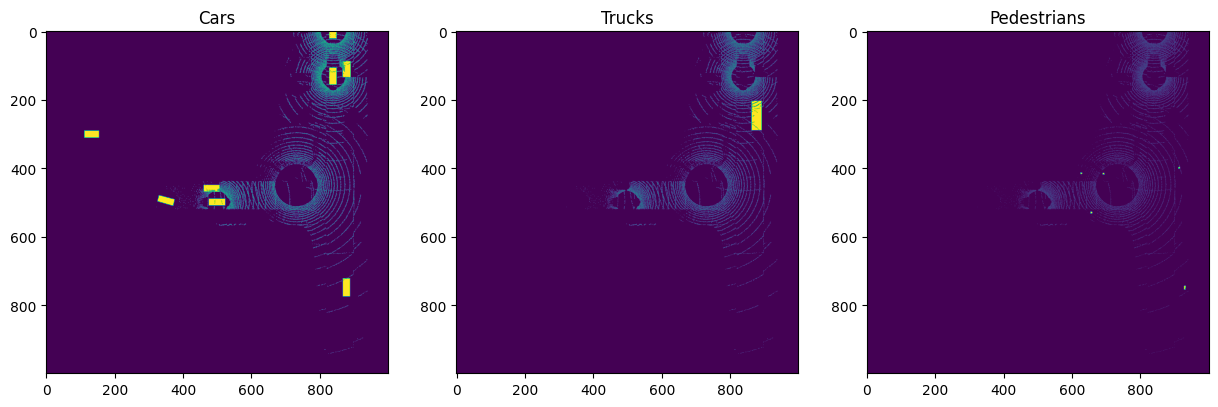

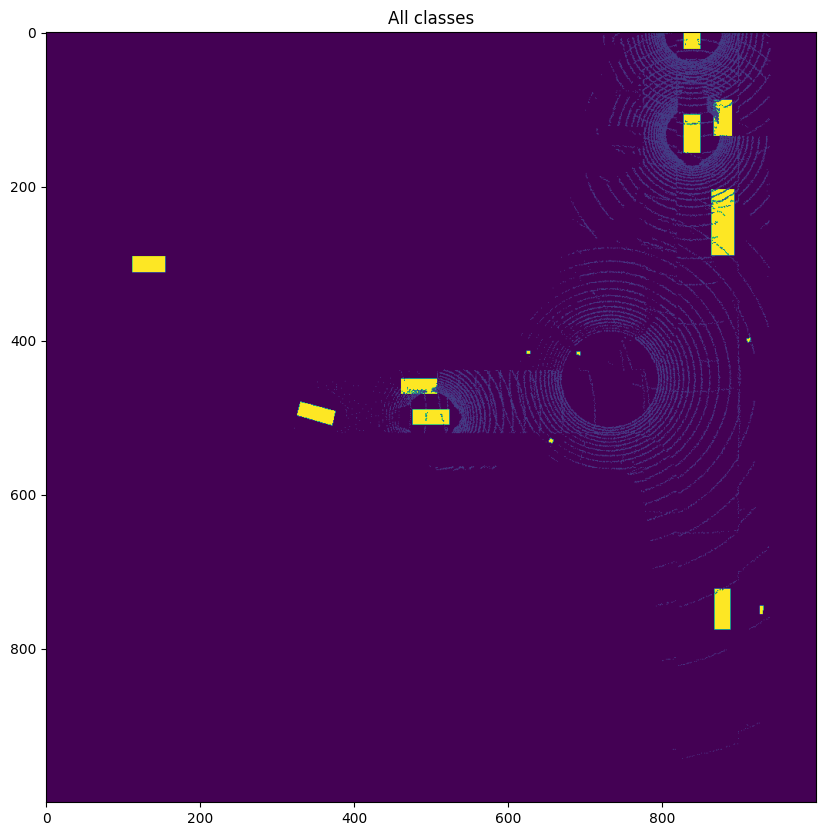

In [5]:

n_frame = 0
actors = ["ego_vehicle" ,"other_vehicle",   "ego_vehicle_behind","other_vehicle_behind","infrastructure",]
merged_points = get_available_point_clouds(n_frame, actors)
irsu_boxes = get_available_boxes_in_ego_frame(n_frame, actors)
box_colors = CLASS_COLORS[irsu_boxes[:, -1].astype(np.int32)]
# divide the boxes into different classes
car_boxes = irsu_boxes[irsu_boxes[:, -1] == 0]
truck_boxes = irsu_boxes[irsu_boxes[:, -1] == 1]
pedestrian_boxes = irsu_boxes[irsu_boxes[:, -1] == 3]

# ------------------ Get Waypoints that belongs to the ground floor ------------------
points_range = np.array([-50, -50, -25, 50, 50, 0.01])  # xmin, ymin, zmin, xmax, ymax, zmax (meters) around ego_vehicle

filtered_points = filter_points(merged_points, points_range)
show_objects(filtered_points, irsu_boxes[:,:7], box_colors)

# ------------------  Build BEV image  ------------------  
bev_resolution = 0.1 # meters / pixel
bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))

# function to create a bev map for a single class
def create_bev_map(bev_resolution, filtered_points, class_boxes, points_range, color_value):
    bev_imsize = np.ceil((points_range[3: 5] - points_range[:2]) / bev_resolution).astype(int)  # (width, height)
    bev_occupancy = np.zeros((bev_imsize[1], bev_imsize[0]))
    for i in range(class_boxes.shape[0]):
        box_mask = box_to_pixels(class_boxes[i:i+1,:7], bev_imsize, bev_resolution)
        bev_occupancy[box_mask > 0] = 255
    
    navigable_space = points_to_pixels(filtered_points, bev_imsize, bev_resolution)

    for pixel in navigable_space:
        bev_occupancy[round(pixel[1]), round(pixel[0])] = color_value
    return bev_occupancy

# create bev maps for each class
bev_cars = create_bev_map(bev_resolution, filtered_points, car_boxes, points_range, 150)
bev_trucks = create_bev_map(bev_resolution, filtered_points, truck_boxes, points_range, 100)
bev_pedestrians = create_bev_map(bev_resolution, filtered_points, pedestrian_boxes, points_range, 50)

# create a bev map for lidar points
bev_lidar = create_bev_map(bev_resolution, filtered_points, irsu_boxes[irsu_boxes[:, -1] == 2], points_range, 255)

# create a bev map for all classes except lidar
bev_total = bev_cars + bev_trucks + bev_pedestrians - bev_lidar

# plot the bev maps
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.imshow(bev_cars)
plt.title('Cars')

plt.subplot(1,3,2)
plt.imshow(bev_trucks)
plt.title('Trucks')

plt.subplot(1,3,3)
plt.imshow(bev_pedestrians)
plt.title('Pedestrians')

plt.figure(figsize=(10, 10))
plt.imshow(bev_total)
plt.title('All classes')

plt.show()

# Task n°4: 
Segment points according to object's class

In [7]:
# Each detection is attached with one class label, use it to filter out the detections of interest (e.g. vehicles, pedestrians, etc.)
# done in task 3